# Step 0: Import Package

In [672]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

# Step 1: Define Problem

Our problem is to predict the passenger survived rate of titanic.

# Step 2: Gather Data

We use the data from Kaggle

In [558]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Step 3: Preparing Data

In [559]:
X = train.drop('Survived',axis = 1)
y = train.Survived
X['flag'] = 1
test['flag'] = 0
combind = pd.concat([X,test],ignore_index=True)

### Step 3.1 Aberrant values/ Outliers

In [560]:
# train.describe(include = 'all')
train.describe()
test.describe()
# combind.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,flag
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.0
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.0
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.0
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.0
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.0
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.0
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,0.0
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,0.0


We can see all values are reasonable. So we don't need to remove outliers

By the way, we can see that some ages are not integer, I measure these value to be uncertain ages.

### Step 3.2 NA Values

In [561]:
# train1.isnull().sum()
# test.isnull().sum()
combind.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
flag              0
dtype: int64

There are some NA values in *age* and *Embarked*. There are lots of missing value for *Cabin*, so we might drop it.

Also, there are 1 missing value of Fare in test set

###### Step 3.21 Fill Missing Age

First, we create a new predictor called *title*, which indicates the title of a person, such as "Mr" and "Mrs". Here, we will fill missing age by the median.

In [562]:
title = combind.Name.str.extractall(r'([A-Z]{1}[a-z]+\.)')[0].reset_index().drop(['level_0','match'],axis = 1)
# title.value_counts()

combind["title"] = title
# combind.sample(5)

In [563]:
# Use only training data
train1 = combind[combind.flag == 1]
# Create a dict for each title corresponding to mean ages
age_median_dict = train1.groupby('title').Age.median().to_dict()
# Identified missing age index
missing_age = combind[combind.Age.isnull()]
# fill out missing ages
missing_age.Age = missing_age['title'].map(age_median_dict)
# impute to original dataset
combind.ix[missing_age.index,'Age'] = missing_age.Age


/Users/Yunhao/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/Yunhao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


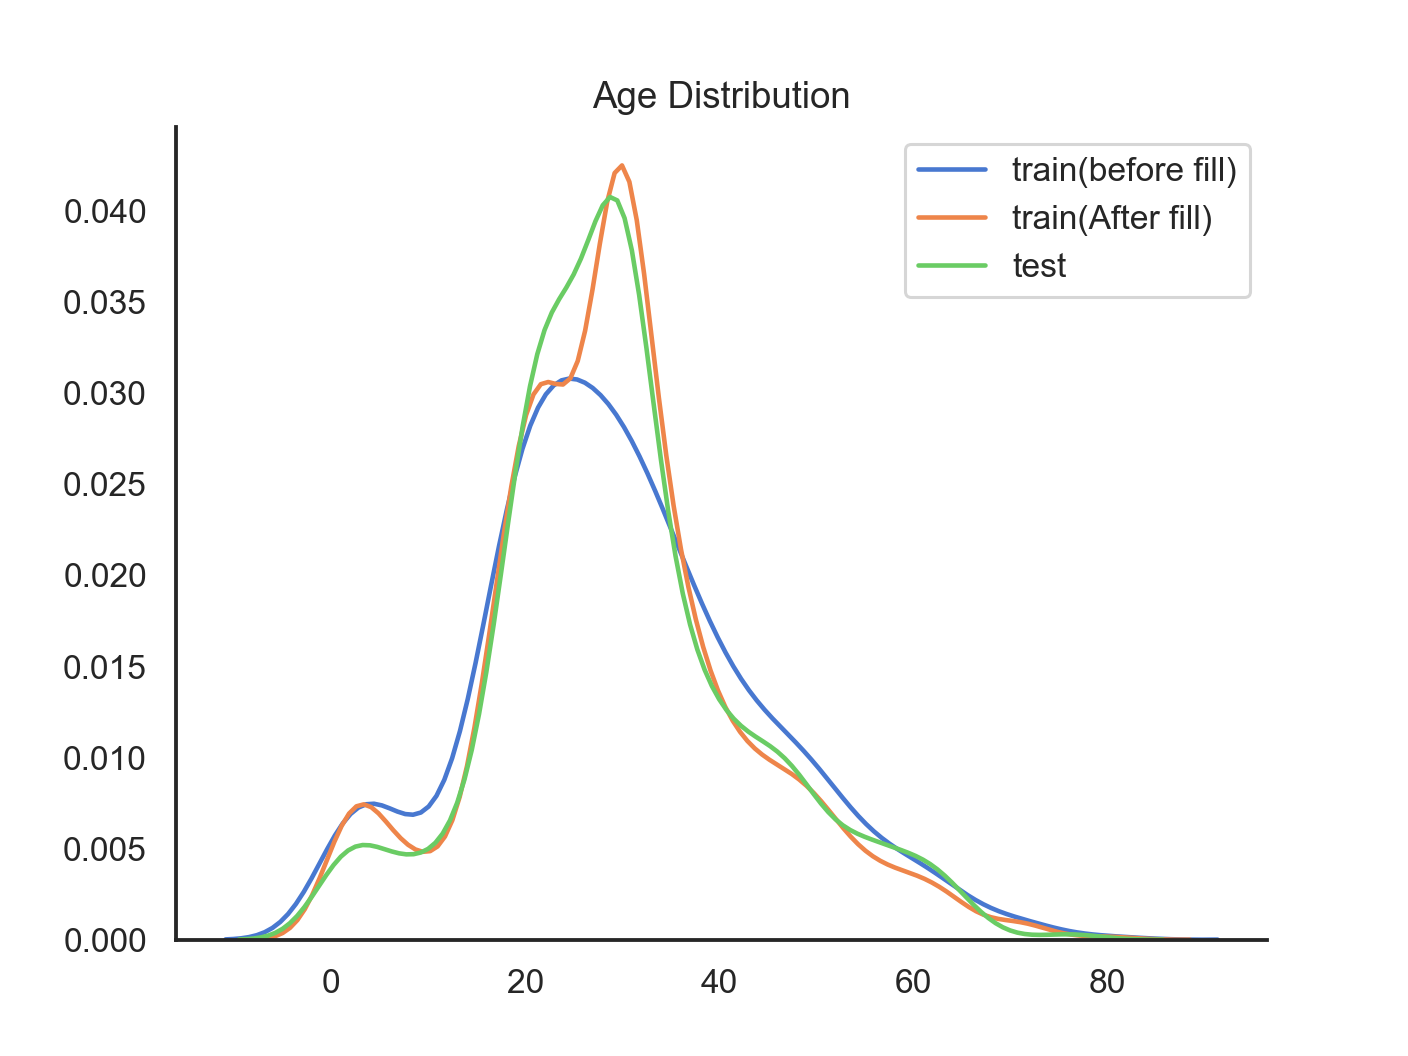

/Users/Yunhao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [564]:
sns.set(style="white", palette="muted", color_codes=True)
plt.figure()
sns.kdeplot(train.Age[train.Age.notnull()],label = 'train(before fill)')
sns.kdeplot(combind[combind.flag == 1].Age,label = 'train(After fill)')
sns.kdeplot(combind[combind.flag == 0].Age,label = 'test')
plt.title('Age Distribution')

sns.despine(right=True);

###### Step 3.22 Fill Embarked

Here, we will use most frequenct appearance method to fill missing *Embarked* values. We use the most frequent class in training set to fill both training and testing data.

In [565]:
combind.Embarked.fillna(train1.Embarked.mode()[0],inplace = True)
combind.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
flag              0
title             0
dtype: int64

###### Step 3.23 Fill Fare

In [566]:
combind[combind.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,flag,title
1043,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0,Mr.


Since there are only 1 missing value of Fare in test set, we can simply impute it with the mean of Fare of Pclass = 3

In [567]:
median_price = combind.groupby('Pclass')['Fare'].median()
combind.Fare.fillna(median_price[3],inplace = True)
combind.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
flag              0
title             0
dtype: int64

##### Step 3.23 Fill Cabin

In [568]:
# combind.Cabin = combind.Cabin.str.extract(r'([A-Z]{1})[0-9]+')
# combind.Cabin.fillna('U',inplace = True)
    

##### Step 3.24 Processing Ticket


In [569]:
# # remove all punctation
# def word_preprocessing(series):
#     from nltk.tokenize import RegexpTokenizer

#     tokenizer = RegexpTokenizer(r'[A-Za-z0-9 ]+')
#     temp = [tokenizer.tokenize(x) for x in series]
#     return [''.join(x) for x in temp]
# train.Ticket = word_preprocessing(train.Ticket)

# ticket = train.Ticket.str.extractall(r'(?P<ticket_title>[A-Za-z0-9/.]*) (?P<ticket_number>\d+)')
# ticket = ticket.reset_index().drop('match',axis = 1).set_index('level_0')
# index_ = train.index.isin([x for x in ticket.index])
# ticket1 = train[~index_].Ticket.str.extractall(r'(?P<ticket_number>\d+)')
# ticket1 = ticket1.reset_index().drop('match',axis = 1).set_index('level_0')

# new_train = train.merge(ticket, left_index = True, right_index = True, how = 'left' )
# new_train.update(ticket1, raise_conflict=True)


### Step 3.3 EDA & Feature Engineering (Simple version)

In [570]:
train1 = combind[combind.flag == 1]

First, let's do some EDA to have some idea of each predictors in training set.


<IPython.core.display.Javascript object>


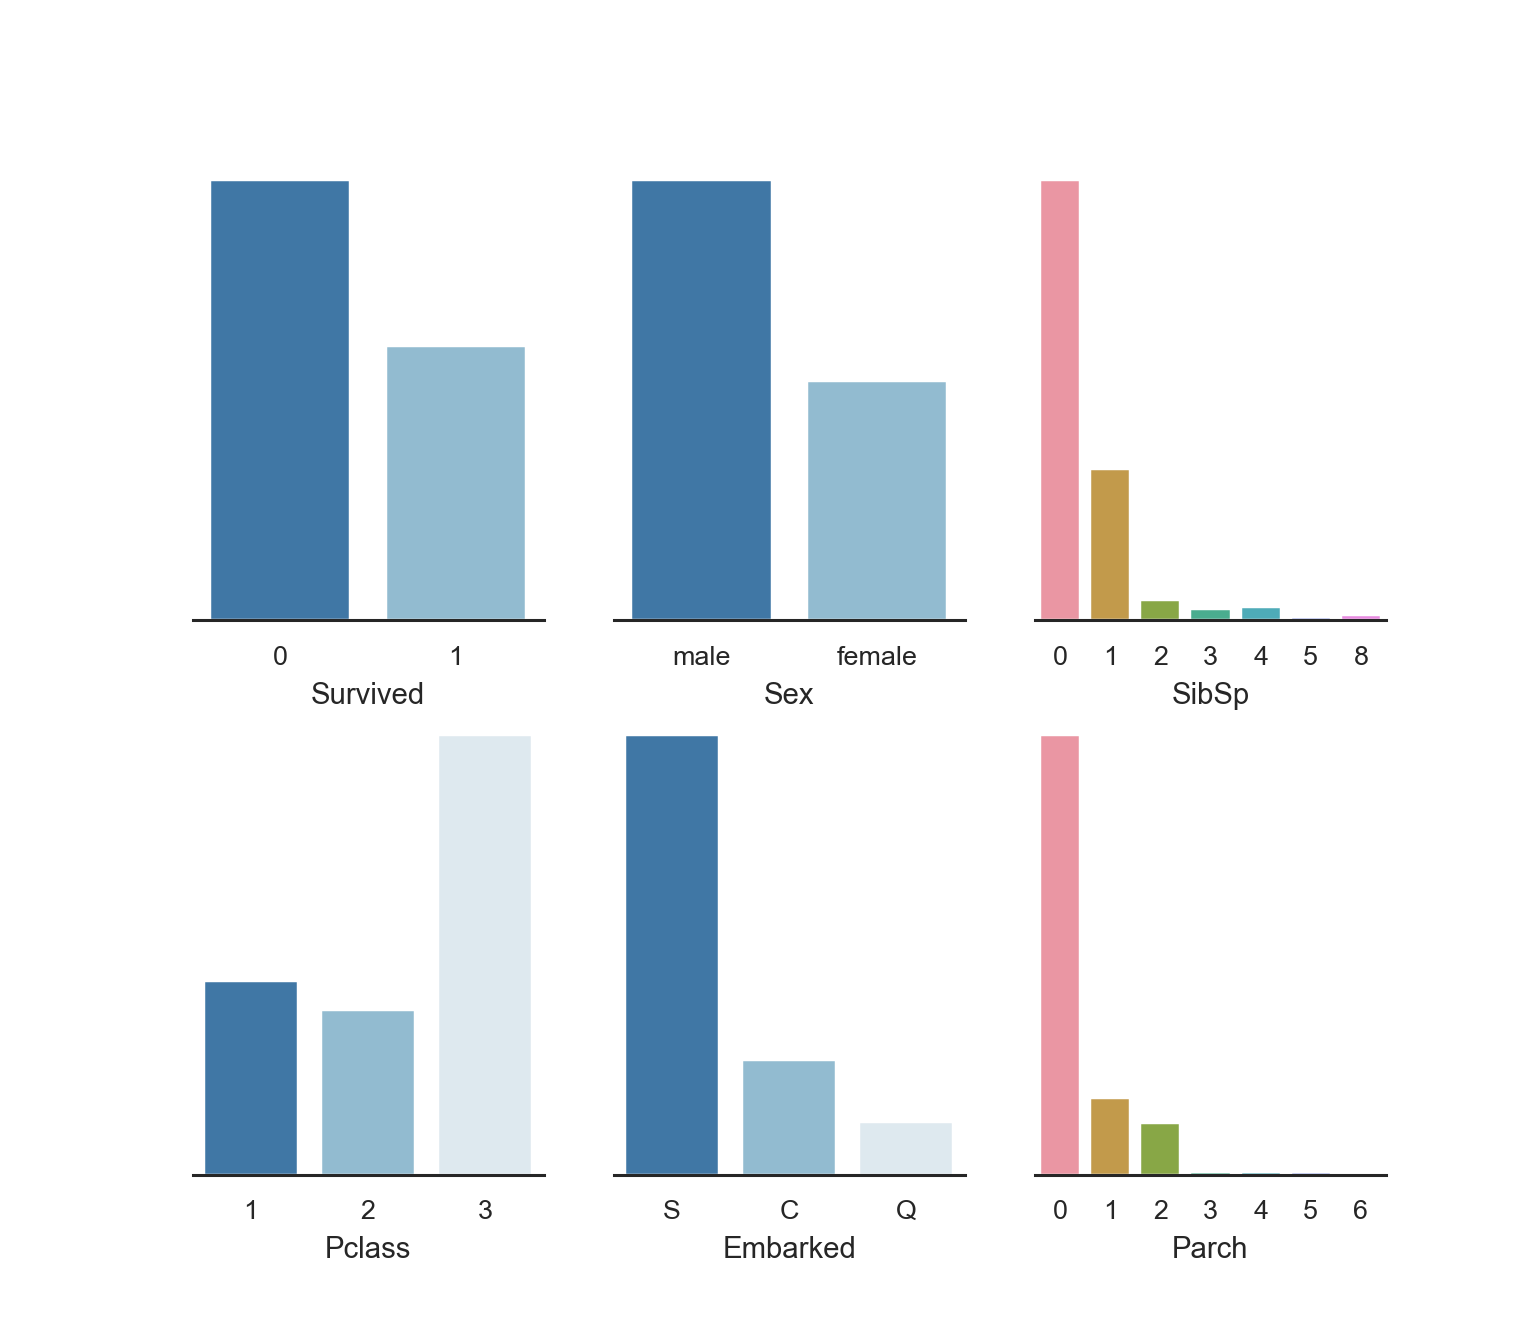

In [571]:
# Base setting
sns.set_palette("RdBu_r",6)
sns.set_context("paper")

# subplots
f,ax = plt.subplots(2,3,figsize = (7,6))
sns.despine(left=True)
sns.countplot(y,ax = ax[0,0])
sns.countplot('Sex',data = train1,ax = ax[0,1])
sns.countplot('SibSp',data = train1,ax = ax[0,2])
sns.countplot('Parch',data = train1,ax = ax[1,2])
sns.countplot('Pclass',data = train1,ax = ax[1,0])
sns.countplot('Embarked',data = train1,ax = ax[1,1])

plt.setp(ax, ylabel='')
plt.setp(ax, yticks =[]);

From the plot we can see that, *SibSp* and *Parch* has very similar distribution. As we know, *SibSp* and *Parch* indicates the number of Sibling/Spouse and Parents /Children, respectively. We can combind them together to be a new feature called *Family Size*


In [572]:
# define familysize = sibsp + parch + 1, if familysize = 1, indicates alone, else travel with family
combind['Family Size'] = combind.SibSp + combind.Parch + 1

Furthermore, intuitively, we can image when disaster come, mother with kids may have higher survival rate, we create a new feature called *is_mother*, a person is considered to be a mother if:

- She is a female
- She is an adult or senior
- She has family size more than 2

In [573]:
is_mother = []
for i,(age,sex,fs) in enumerate(zip(combind.Age,combind.Sex,combind['Family Size'])):
    if ((age >= 25) & (sex == 'female') & (fs > 2)):
        is_mother.append(1)
    else:
        is_mother.append(0)
        
combind['is_mother'] = pd.Series(is_mother)

<IPython.core.display.Javascript object>


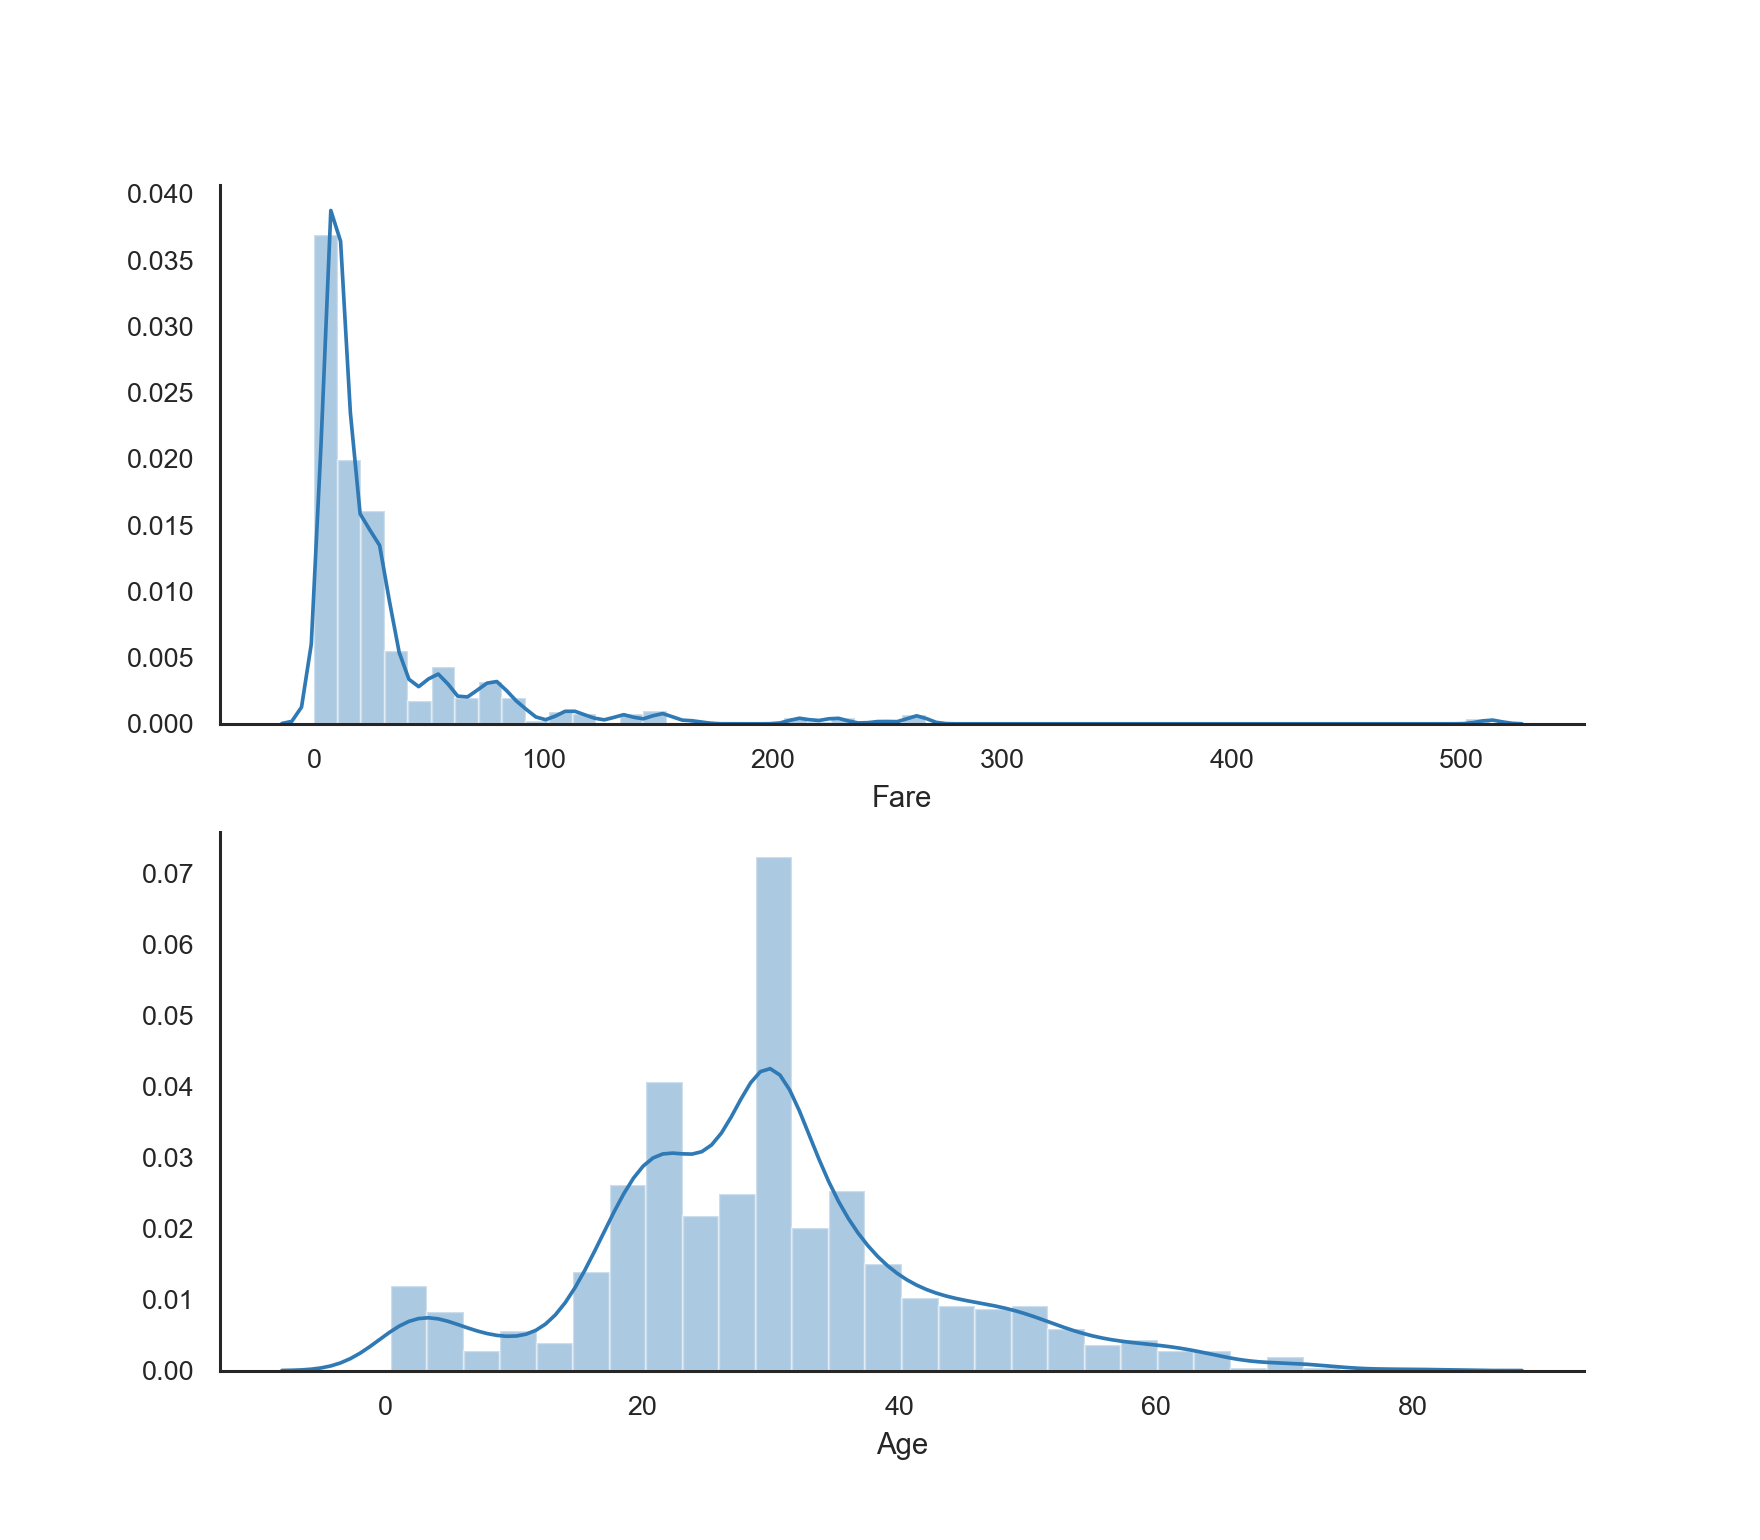

In [574]:
f,ax = plt.subplots(2,1,figsize = (8,7))
sns.despine(right=True)

sns.distplot(train1.Fare,ax = ax[0])
sns.distplot(train1.Age,ax = ax[1])


plt.setp(ax, ylabel='');

# plt.setp(ax, yticks =[]);

In [204]:
train1.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
flag           0
title          0
dtype: int64

We can divide age into groups:
- Baby (0 - 5)
- Child (5 - 12)
- Teenager (12 - 18)
- Young Adult (18 - 25)
- Adult (25 - 40)
- Senior (40+)

We also can divide fare into groups:

- Low
- Median_low
- Median_high
- High

In [575]:
def age_group(df):
    bins = (0,5,12,18,25,40,140)
    group_names = ['Baby','Child','Teenager','Young Adult','Adult','Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def fare_group(df):
    bins = (-1,8,15,31,1000)
    group_names = ['Low','Median_low','Median_high','High']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df
def title_group(df):
    Title_Dictionary = {
        "Capt.": "Officer",
        "Col.": "Officer",
        "Major.": "Officer",
        "Jonkheer.": "Royalty",
        "Don.":"Royalty",
        "Dona.": "Royalty",
        "Sir." : "Royalty",
        "Dr.": "Officer",
        "Rev.": "Officer",
        "Countess.":"Royalty",
        "Mme.": "Mrs",
        "Mlle.": "Miss",
        "Ms.": "Mrs",
        "Mr." : "Mr",
        "Mrs." : "Mrs",
        "Miss." : "Miss",
        "Master." : "Master",
        "Lady." : "Royalty"
    }
    df['title'] = df['title'].map(Title_Dictionary)
    return df

def transform_features(df):
    rare_title = df.title.value_counts()[df.title.value_counts() < 50].index
    df = age_group(df)
    df = fare_group(df)
    df = title_group(df)
    return df

combind = transform_features(combind)

###### Step 3.31 Feature Encoding

In [576]:
# drop Name, Ticket, PassengerId
combind.drop(['Name','Ticket','Cabin','PassengerId'],axis = 1,inplace =True)
combind.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,flag,title,Family Size,is_mother
0,3,male,Young Adult,1,0,Low,S,1,Mr,2,0
1,1,female,Adult,1,0,High,C,1,Mrs,2,0
2,3,female,Adult,0,0,Low,S,1,Miss,1,0
3,1,female,Adult,1,0,High,S,1,Mrs,2,0
4,3,male,Adult,0,0,Median_low,S,1,Mr,1,0


For feature encoding, we assume Captain paid more attention to children and female, also since The higher the fare you paid, the upper decks you will live in, so we can encode as follow.  

In [577]:
age_dict = {'Baby':5,'Child':4,'Teenager':3,'Young Adult':2,'Adult':1,'Senior':0}
Fare_dict = {'Low':0,'Median_low':1,'Median_high':2,'High':3}
combind.Age = combind.Age.map(age_dict)
combind.Fare = combind.Fare.map(Fare_dict)
combind.Sex = np.where(combind.Sex == 'female',1,0)
combind = pd.get_dummies(combind)
combind.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,flag,Family Size,is_mother,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Officer,title_Royalty
402,3,1,2,1,0,1,1,2,0,0,0,1,0,1,0,0,0,0
1049,1,0,0,0,0,2,0,1,0,0,0,1,0,0,1,0,0,0
445,1,0,5,0,2,3,1,3,0,0,0,1,1,0,0,0,0,0
776,3,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
858,3,1,2,0,3,2,1,4,0,1,0,0,0,0,0,1,0,0


After finishing feature encoding, we can seperate training,validation and testing set back.

In [578]:
X_train = combind[combind.flag == 1].drop('flag',axis = 1)
X_test = combind[combind.flag == 0].drop('flag',axis = 1)

###### Step 3.32 Further EDA

<IPython.core.display.Javascript object>


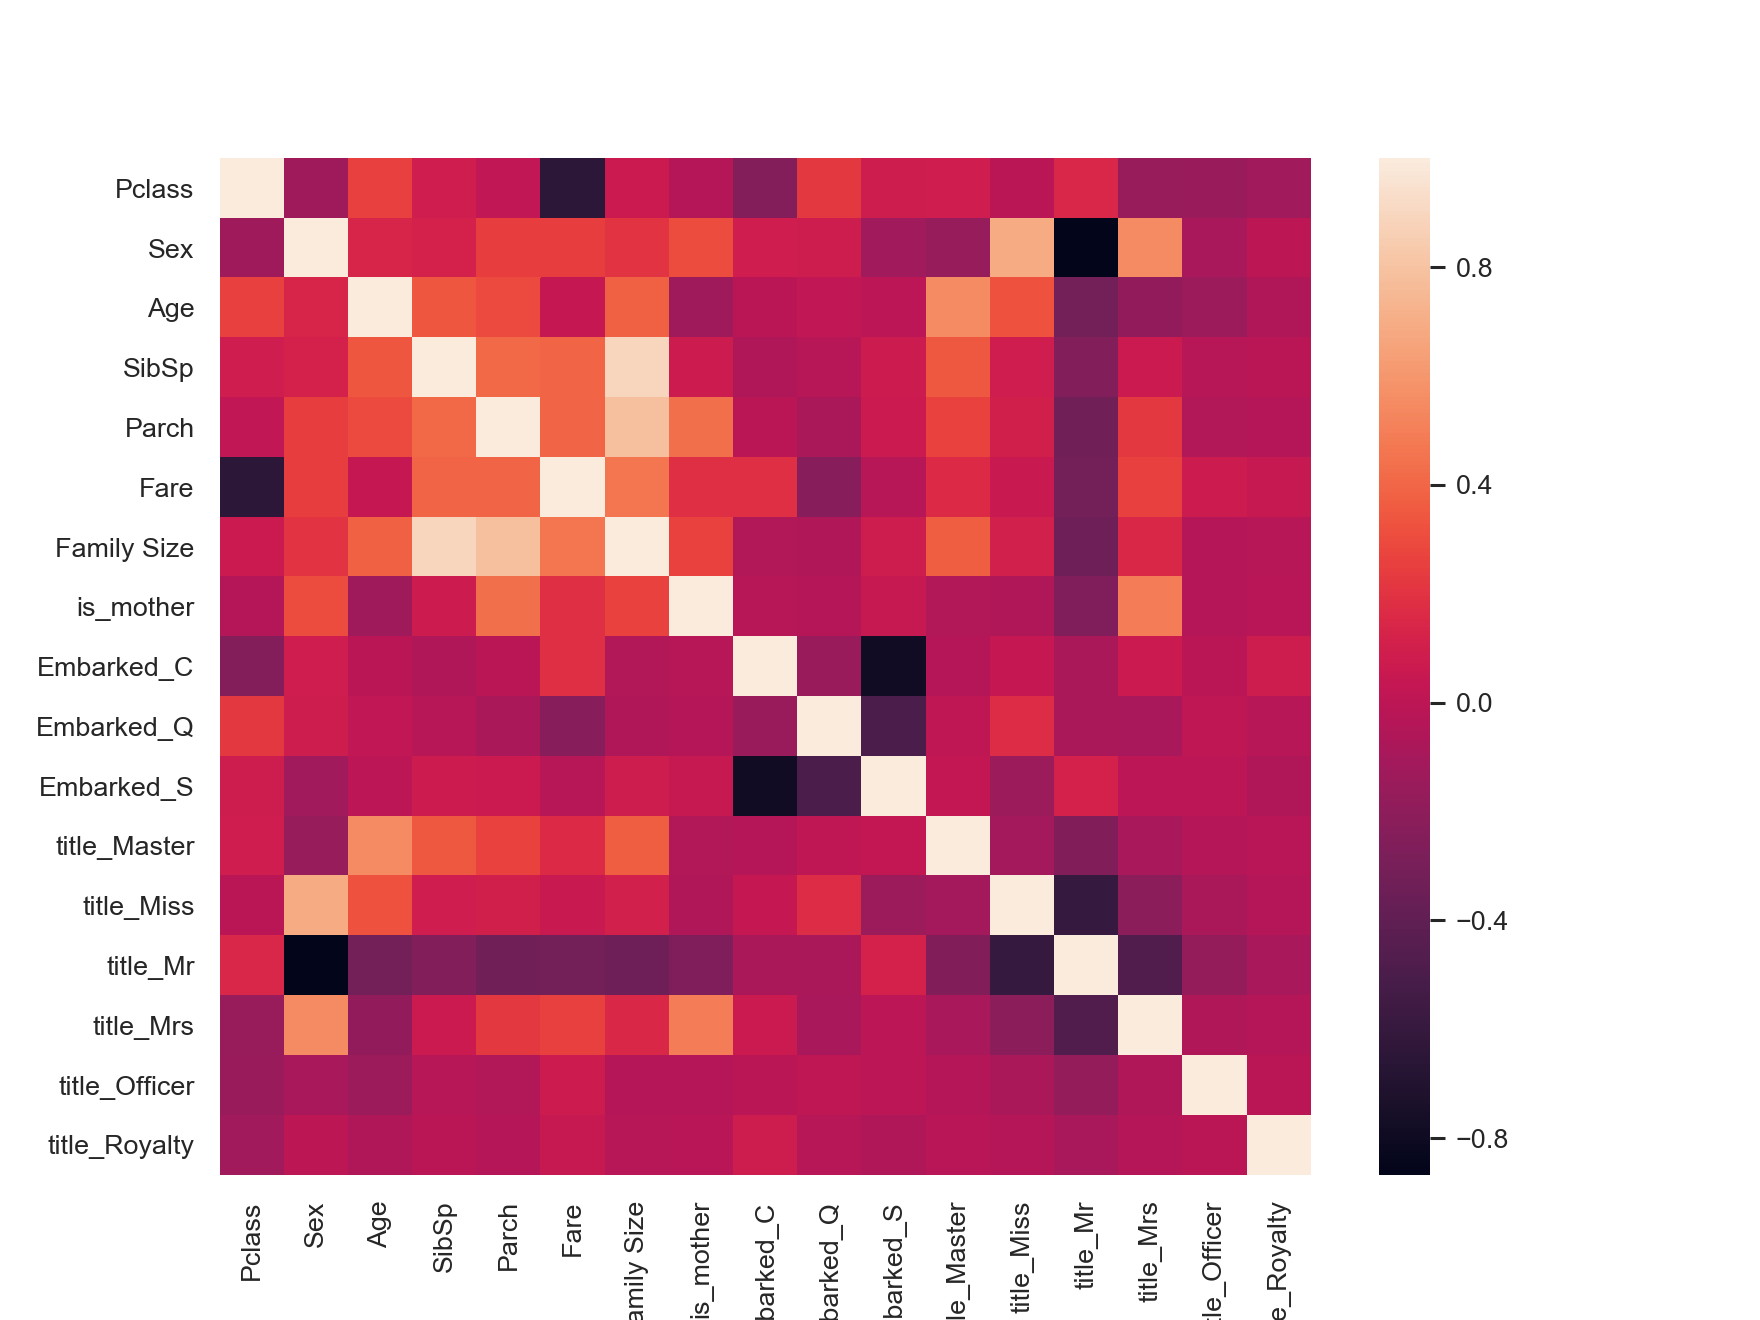

In [579]:
plt.figure(figsize = (8,6))
sns.heatmap(X_train.corr()) 

Let's plot some features v.s. survived rate.

<IPython.core.display.Javascript object>


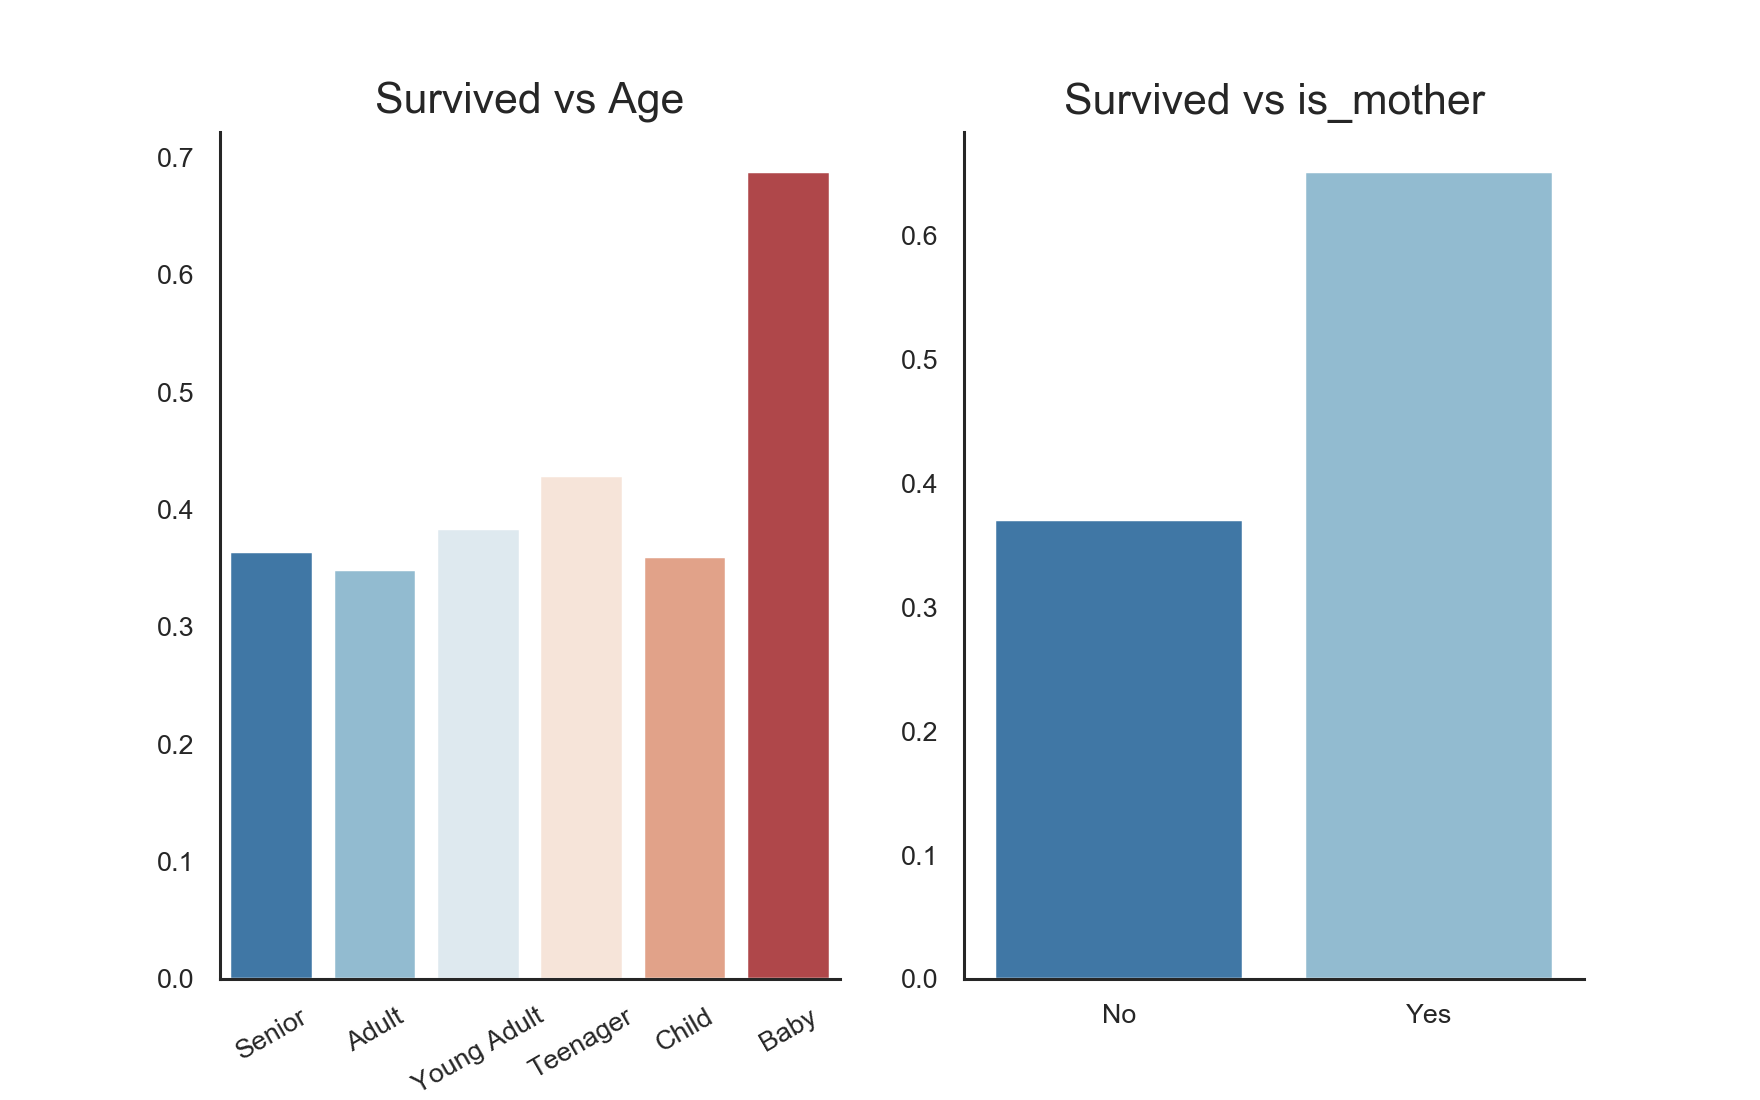

[Text(0.5, 0, ''), Text(0.5, 0, '')]

In [580]:
f,ax = plt.subplots(1,2,figsize = (8,5))
sns.barplot(X_train.Age,y,ci = None,ax = ax[0])
plt.sca(ax[0])
plt.xticks(np.arange(5,-1,-1),['Baby','Child','Teenager','Young Adult','Adult','Senior'],rotation = 30)
plt.title('Survived vs Age',fontsize = 14)

sns.barplot(X_train['is_mother'],y,ci = None,ax = ax[1])
plt.sca(ax[1])
plt.xticks(np.arange(2),['No','Yes'])
plt.title('Survived vs is_mother',fontsize = 14)


sns.despine(right=True)
plt.setp(ax, ylabel='')
plt.setp(ax, xlabel='')
# plt.xlabel('')
# plt.ylabel('')

[Text(0.5, 0, ''), Text(0.5, 0, ''), Text(0.5, 0, ''), Text(0.5, 0, '')]

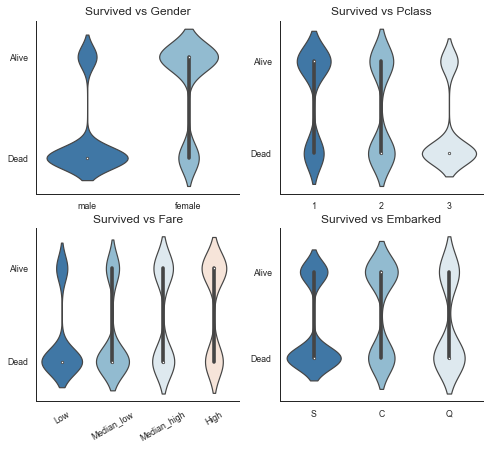

In [37]:
f,ax = plt.subplots(2,2,figsize=(8,7))
sns.violinplot(X_train.Sex,y,ci = None,ax = ax[0,0])
plt.sca(ax[0,0])
plt.xticks(np.arange(2),['male','female'])
plt.yticks(range(2),['Dead','Alive'])
plt.title('Survived vs Gender',fontsize = 12)

sns.violinplot(X_train.Pclass,y,ci = None,ax = ax[0,1])
plt.sca(ax[0,1])
plt.title('Survived vs Pclass',fontsize = 12)
plt.yticks(range(2),['Dead','Alive'])

sns.violinplot(train.Embarked,y,ci = None,ax = ax[1,1])
plt.sca(ax[1,1])
plt.title('Survived vs Embarked',fontsize = 12)
plt.yticks(range(2),['Dead','Alive'])

sns.violinplot(X_train.Fare,y,ci = None,ax = ax[1,0])
plt.sca(ax[1,0])
plt.xticks(np.arange(4),['Low','Median_low','Median_high','High'],rotation = 30)
plt.title('Survived vs Fare',fontsize = 12)
plt.yticks(range(2),['Dead','Alive'])

sns.despine(right=True)
plt.setp(ax, ylabel='')
plt.setp(ax, xlabel='')

<IPython.core.display.Javascript object>


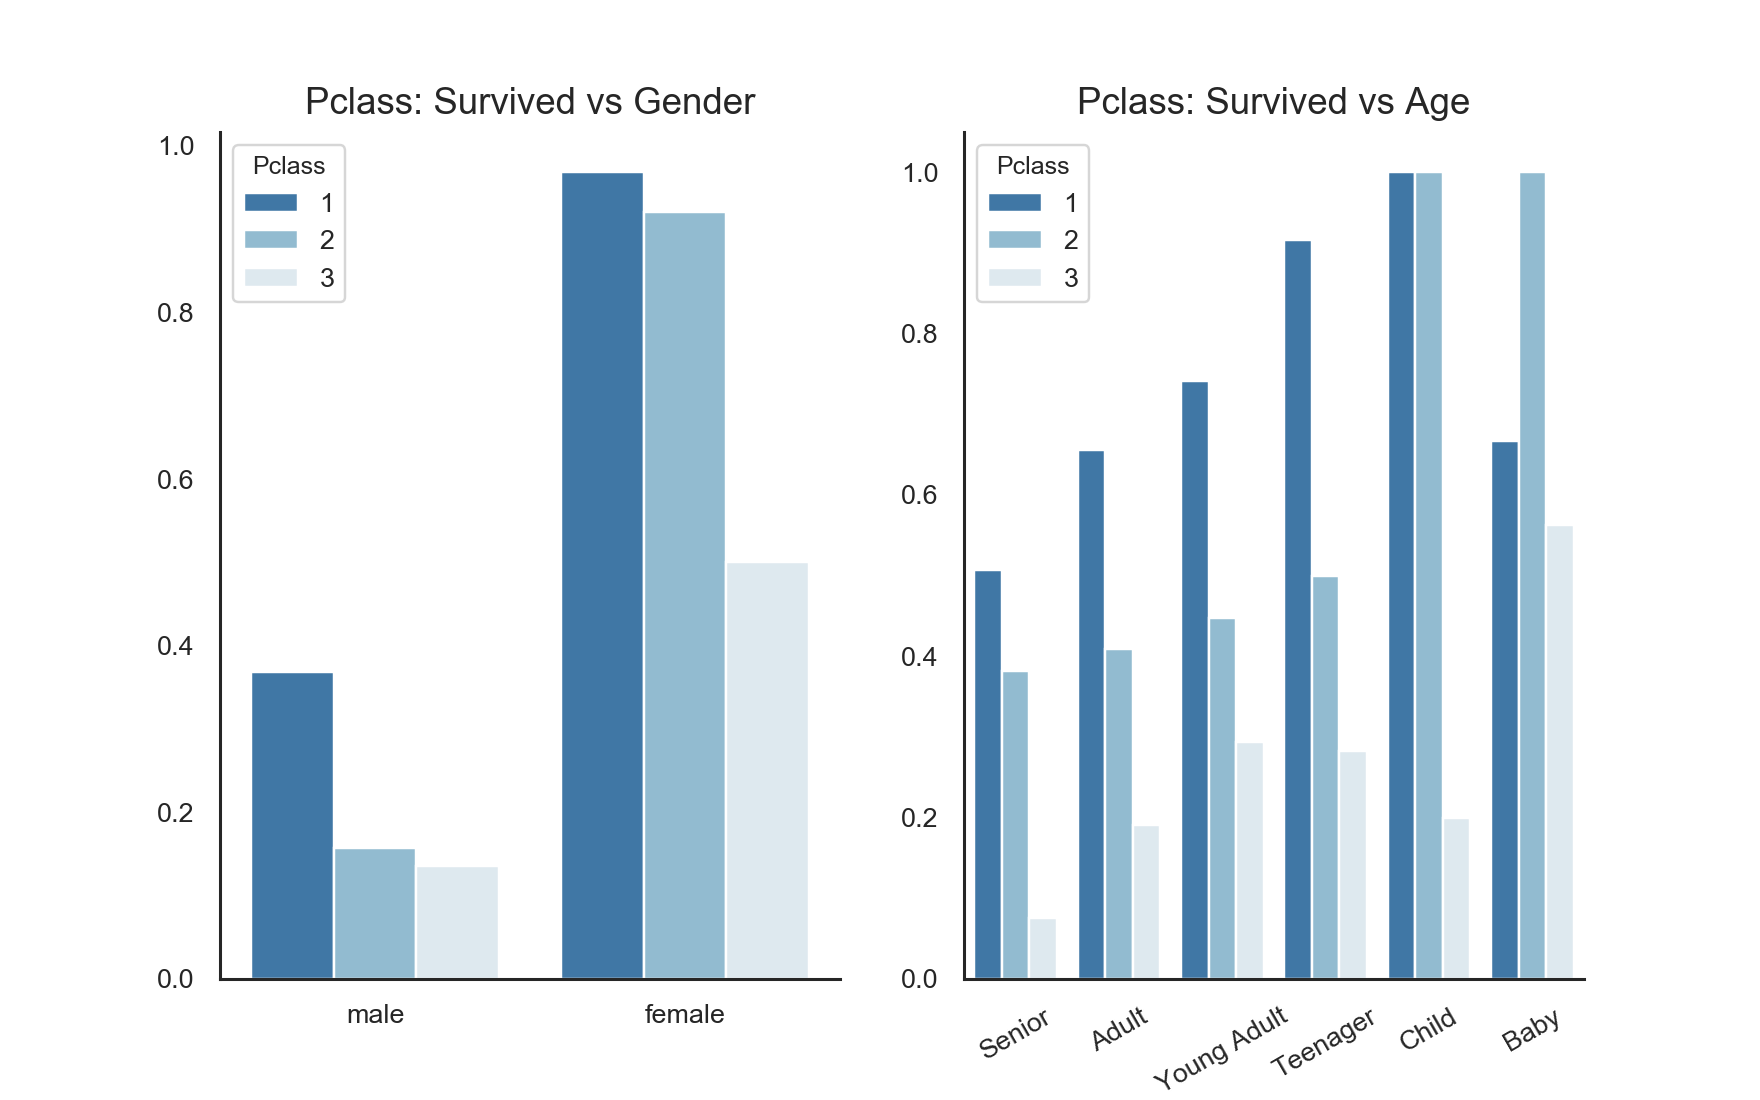

[Text(0.5, 0, ''), Text(0.5, 0, '')]

In [581]:
f,ax = plt.subplots(1,2,figsize=(8,5))
sns.barplot(X_train.Sex,y,hue = X_train.Pclass,ci = None,ax = ax[0])
plt.sca(ax[0])
plt.xticks(np.arange(2),['male','female'])
plt.title('Pclass: Survived vs Gender',fontsize = 12)

sns.barplot(X_train.Age,y,hue = X_train.Pclass,ci = None,ax = ax[1])
plt.sca(ax[1])
plt.xticks(np.arange(5,-1,-1),['Baby','Child','Teenager','Young Adult','Adult','Senior'],rotation = 30)
plt.title('Pclass: Survived vs Age',fontsize = 12)

sns.despine(right=True)
plt.setp(ax, ylabel='')
plt.setp(ax, xlabel='')

[Text(0.5, 0, ''), Text(0.5, 0, '')]

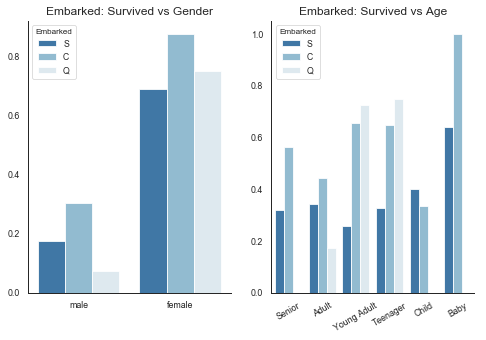

In [39]:


f,ax = plt.subplots(1,2,figsize=(8,5))
sns.barplot(X_train.Sex,y,hue = train.Embarked,ci = None,ax = ax[0])
plt.sca(ax[0])
plt.xticks(np.arange(2),['male','female'])
plt.title('Embarked: Survived vs Gender',fontsize = 12)

sns.barplot(X_train.Age,y,hue = train.Embarked,ci = None,ax = ax[1])
plt.sca(ax[1])
plt.xticks(np.arange(5,-1,-1),['Baby','Child','Teenager','Young Adult','Adult','Senior'],rotation = 30)
plt.title('Embarked: Survived vs Age',fontsize = 12)

sns.despine(right=True)
plt.setp(ax, ylabel='')
plt.setp(ax, xlabel='')

# Step 4 Modeling

In [756]:
# cross validation
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [716]:
def Grid_auc(model,grid_values,name):
    grid_auc = GridSearchCV(model, param_grid = grid_values).fit(X_train,y)
    print('Grid best parameter (max. AUC) of',name,': ', grid_auc.best_params_)
    print('Grid best score (AUC) of',name,': ',grid_auc.best_score_)
    print('-'*50)
    return grid_auc.best_params_

In [745]:
def print_cv_score(model,name,cv):
    score = cross_val_score(model,X_train,y,cv = cv).mean()
    print('Model',name,'CV score: {:.5f}'.format(score))

### Step 4.1 Base Modeling (SVC, Random Forest, KNN, XGB)

In [656]:
# First layer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Second Layer
from sklearn.linear_model import LogisticRegression

# Other package
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


In [761]:
# Define grid values
rf_grid_values = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

Xgb_grid_values = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }

KNN_grid_values = {'n_neighbors':[3,4,5,6,7],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}
SVC_grid_values = {'gamma': ['auto',0.1,1e-2],
                     'C': [1, 10, 100, 1000]}
# Define model
rf = RandomForestClassifier()
xgb = XGBClassifier()
knn = KNeighborsClassifier()
svc = SVC()

grid_values =[rf_grid_values,Xgb_grid_values,KNN_grid_values,SVC_grid_values]
model_set = [rf,xgb,knn,svc]
model_name = ['rf','xgb','knn','svc']

Best_param_set = {}

In [764]:
# run grid search? True or False
run_gs = False

if run_gs:
    for i,(name,model,grid_value) in enumerate(zip(model_name,model_set,grid_values)):
        best_param = Grid_auc(model,grid_value,name)
        Best_param_set[name] = best_param
else:
    rf = RandomForestClassifier(**Best_param_set['rf'])
    xgb = XGBClassifier(**Best_param_set['xgb'])
    knn = KNeighborsClassifier(**Best_param_set['knn'])
    svc = SVC(**Best_param_set['svc'])
    

In [779]:
cv = 5
for name,model in zip(model_name,[rf,xgb,knn,svc]):
    print_cv_score(model,name,cv)

Model rf CV score: 0.82942
Model xgb CV score: 0.81705
Model knn CV score: 0.80480
Model svc CV score: 0.83167


<IPython.core.display.Javascript object>


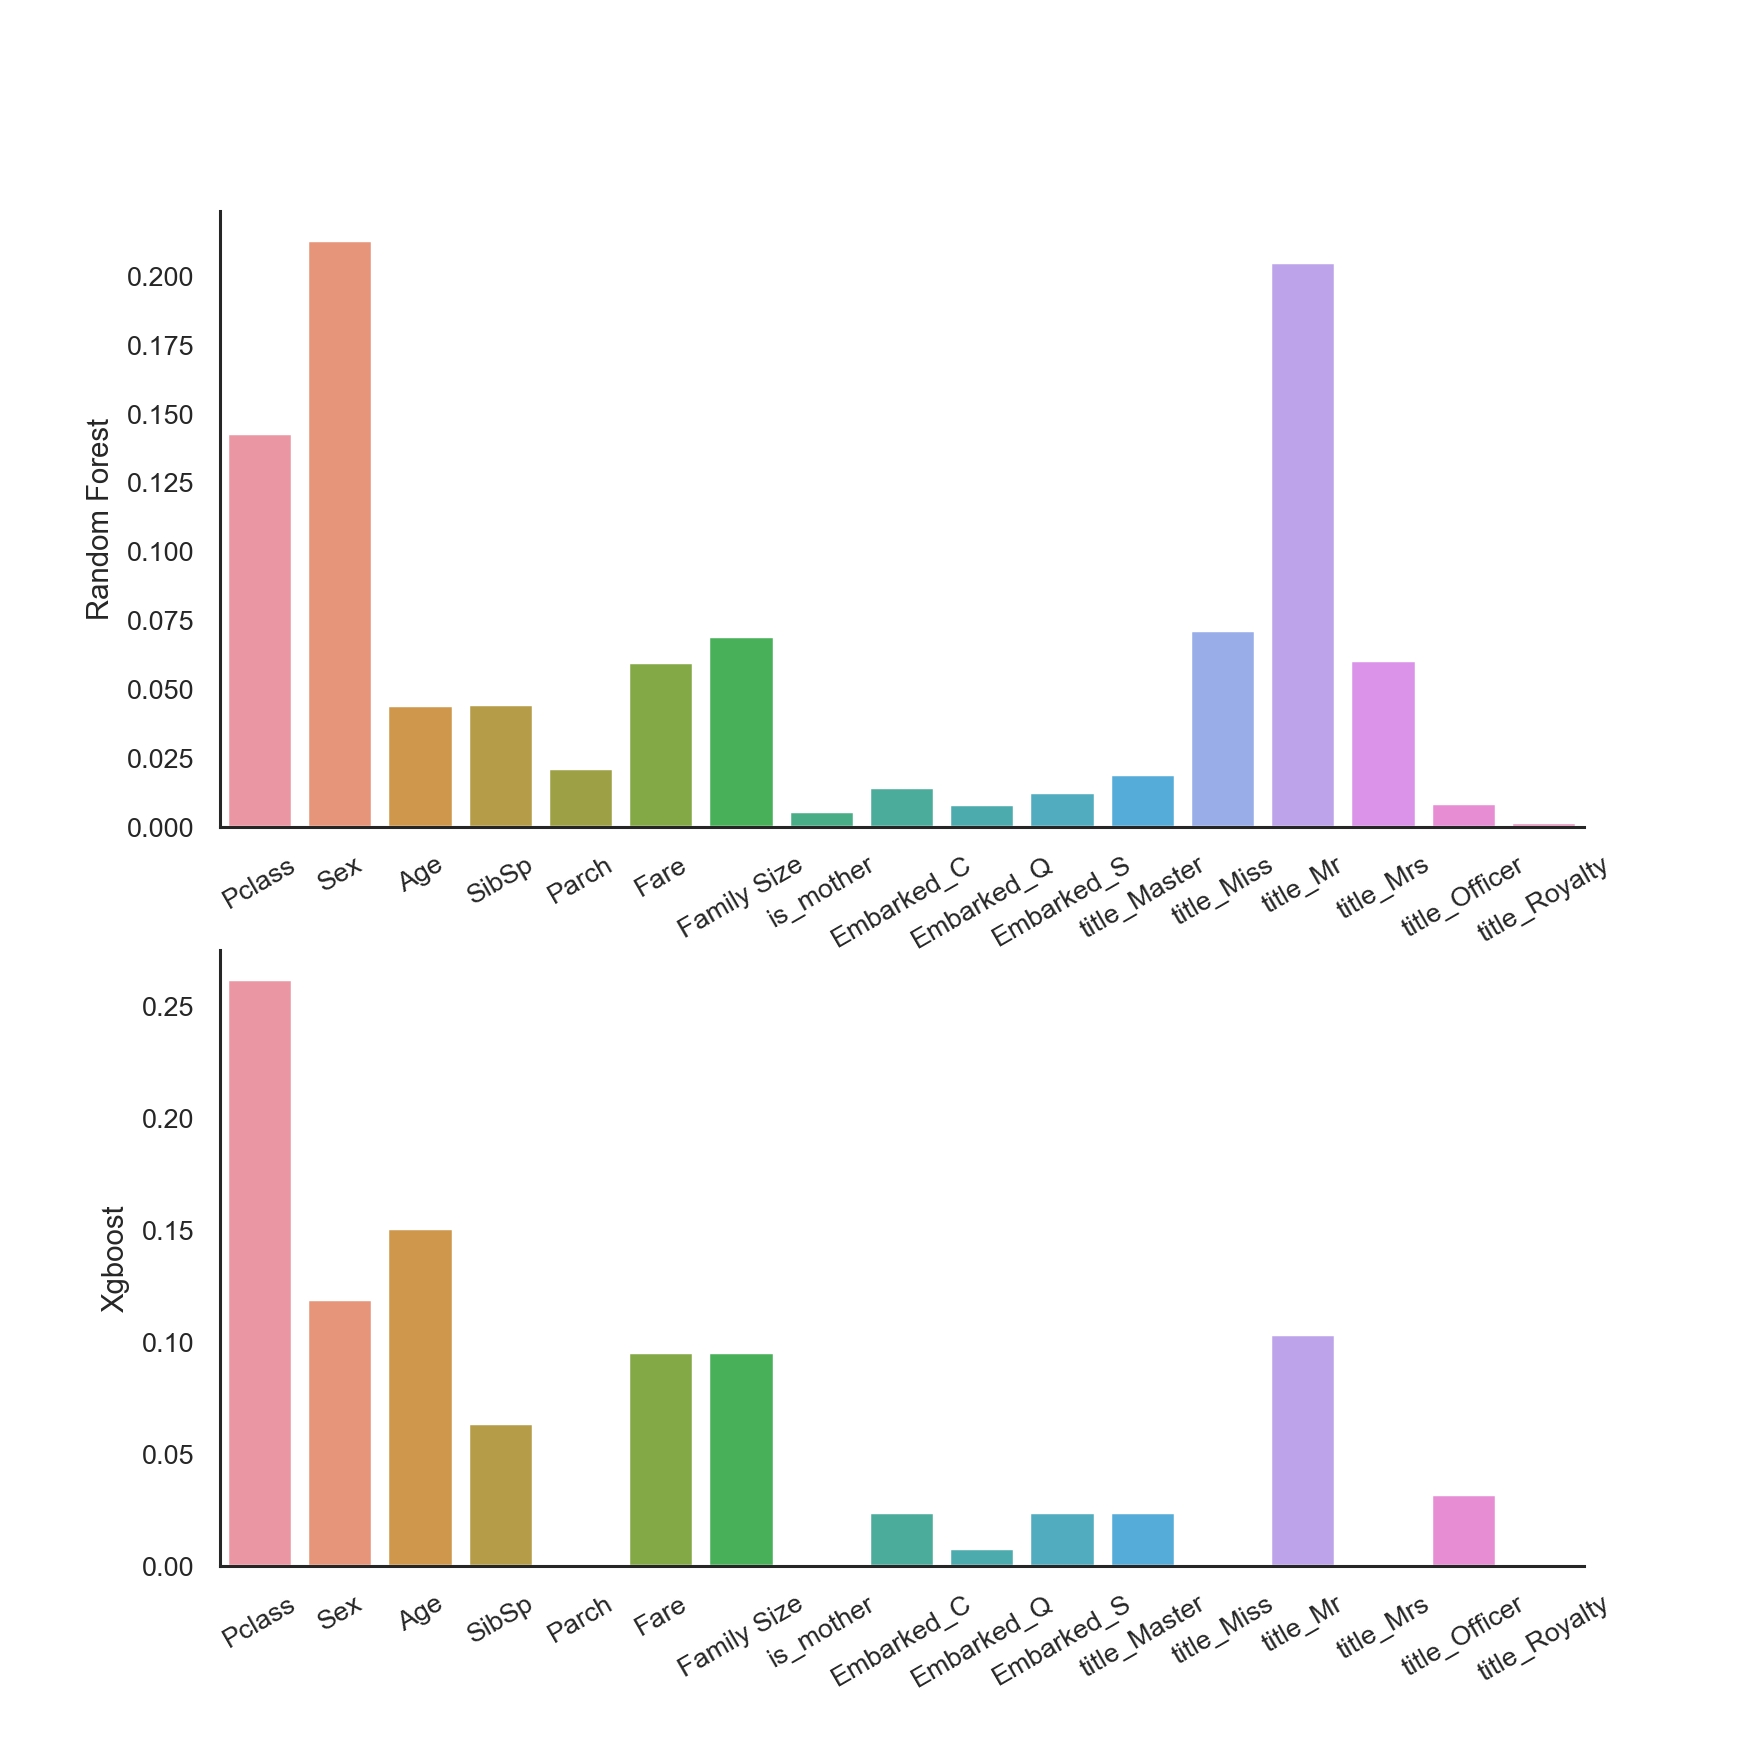

In [821]:
rf_fit = rf.fit(X_train,y)
xgb_fit = xgb.fit(X_train,y)

col = X_train.columns
feature_importance = pd.DataFrame({'features':col,
                                  'Random Forest':rf_fit.feature_importances_,
                                  'Xgboost':xgb_fit.feature_importances_})

f,ax = plt.subplots(2,1,figsize = (8,8))
sns.barplot(np.arange(17),feature_importance['Random Forest'],ax = ax[0])
plt.sca(ax[0])
plt.xticks(np.arange(17),col,rotation = 30)

sns.barplot(np.arange(17),feature_importance['Xgboost'],ax = ax[1])
plt.sca(ax[1])
plt.xticks(np.arange(17),col,rotation = 30);
sns.despine(right=True)
# plt.setp(ax,ylabel = '')

<IPython.core.display.Javascript object>


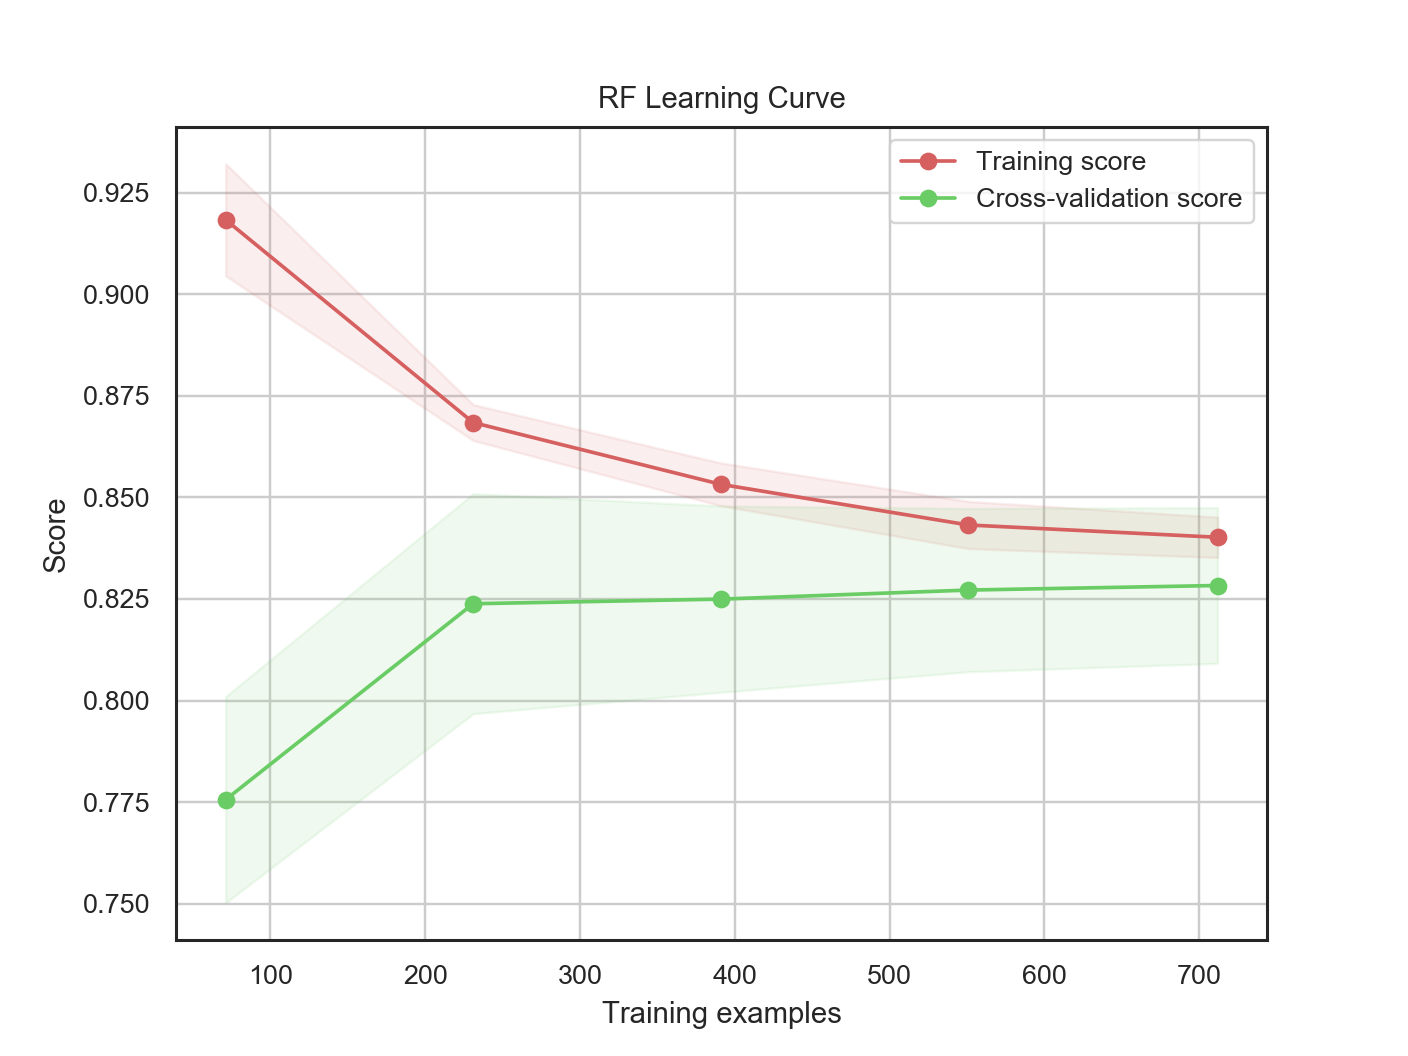

<IPython.core.display.Javascript object>


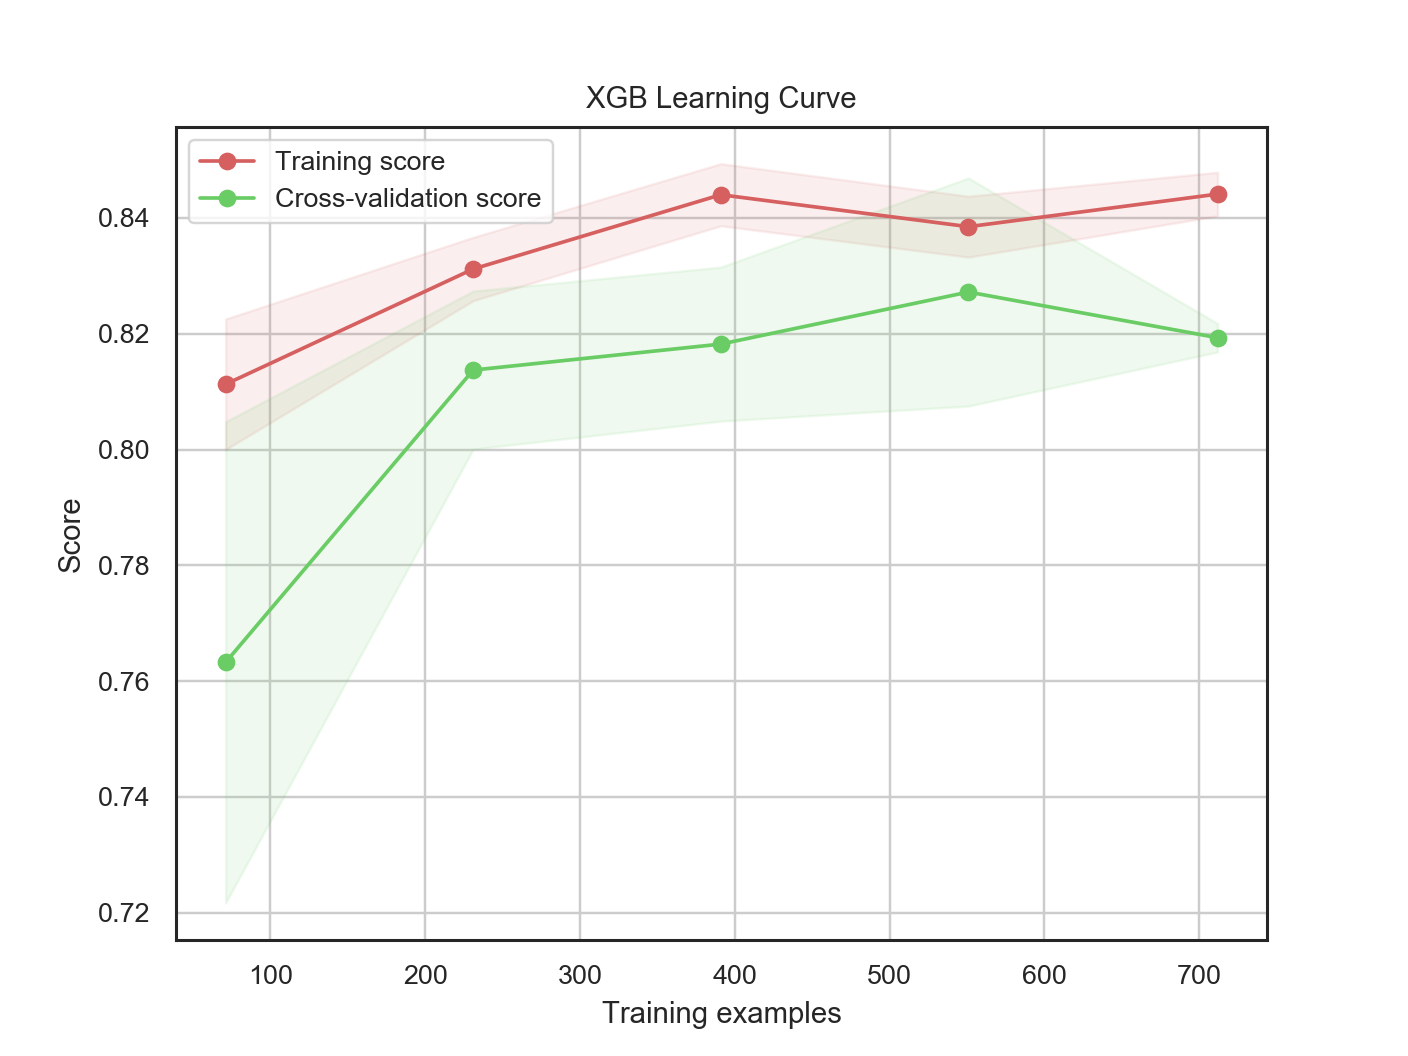

<IPython.core.display.Javascript object>


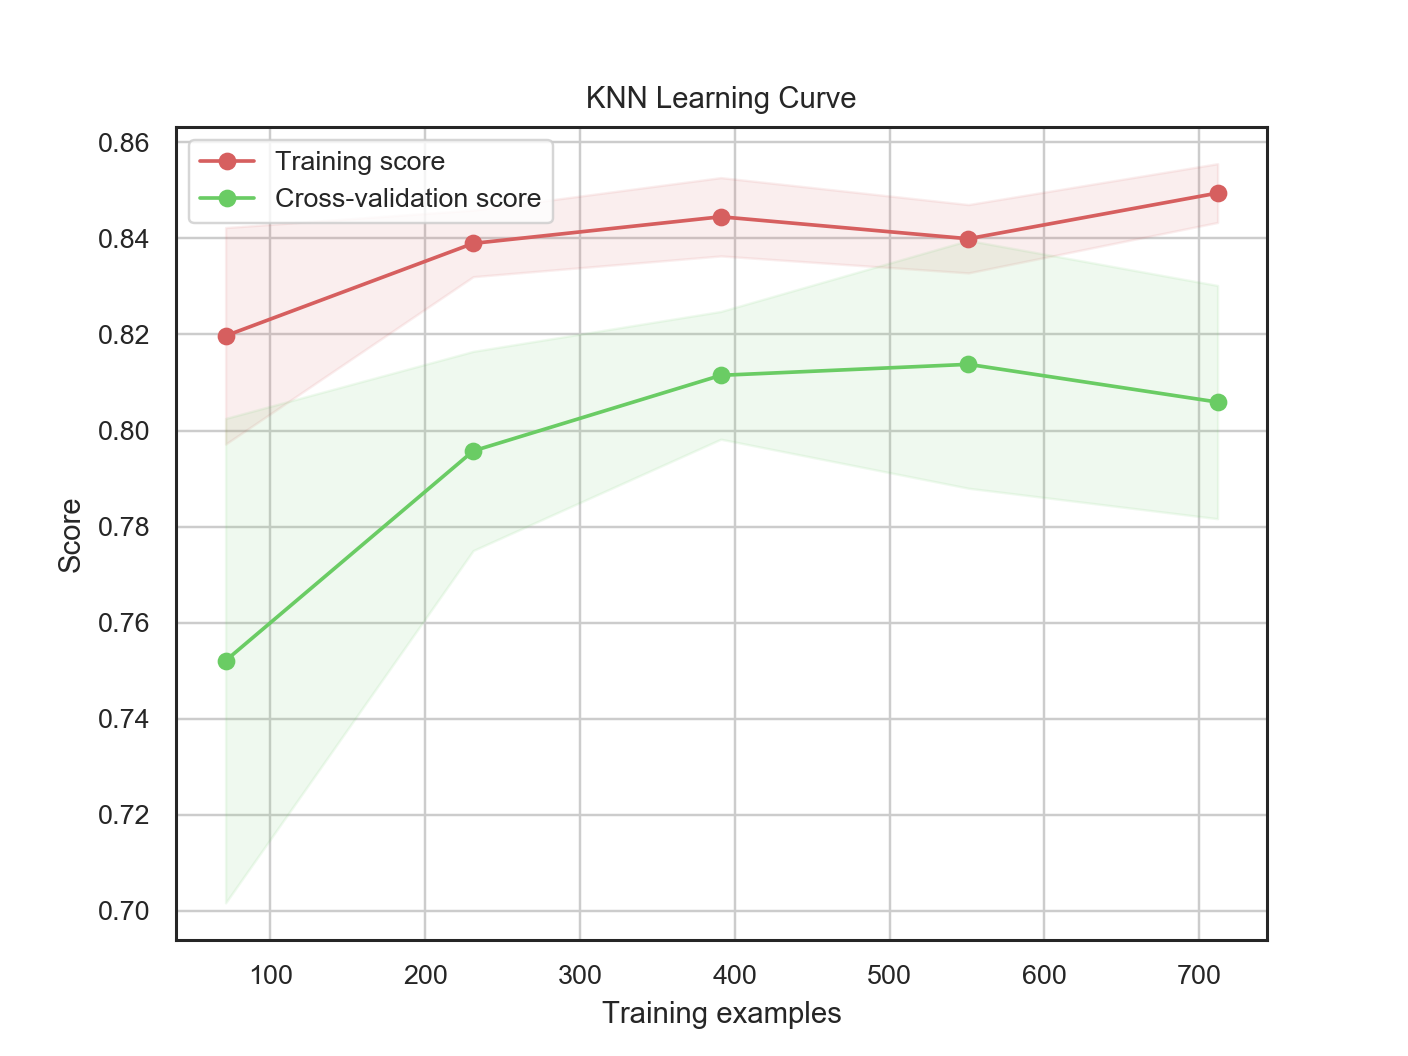

<IPython.core.display.Javascript object>


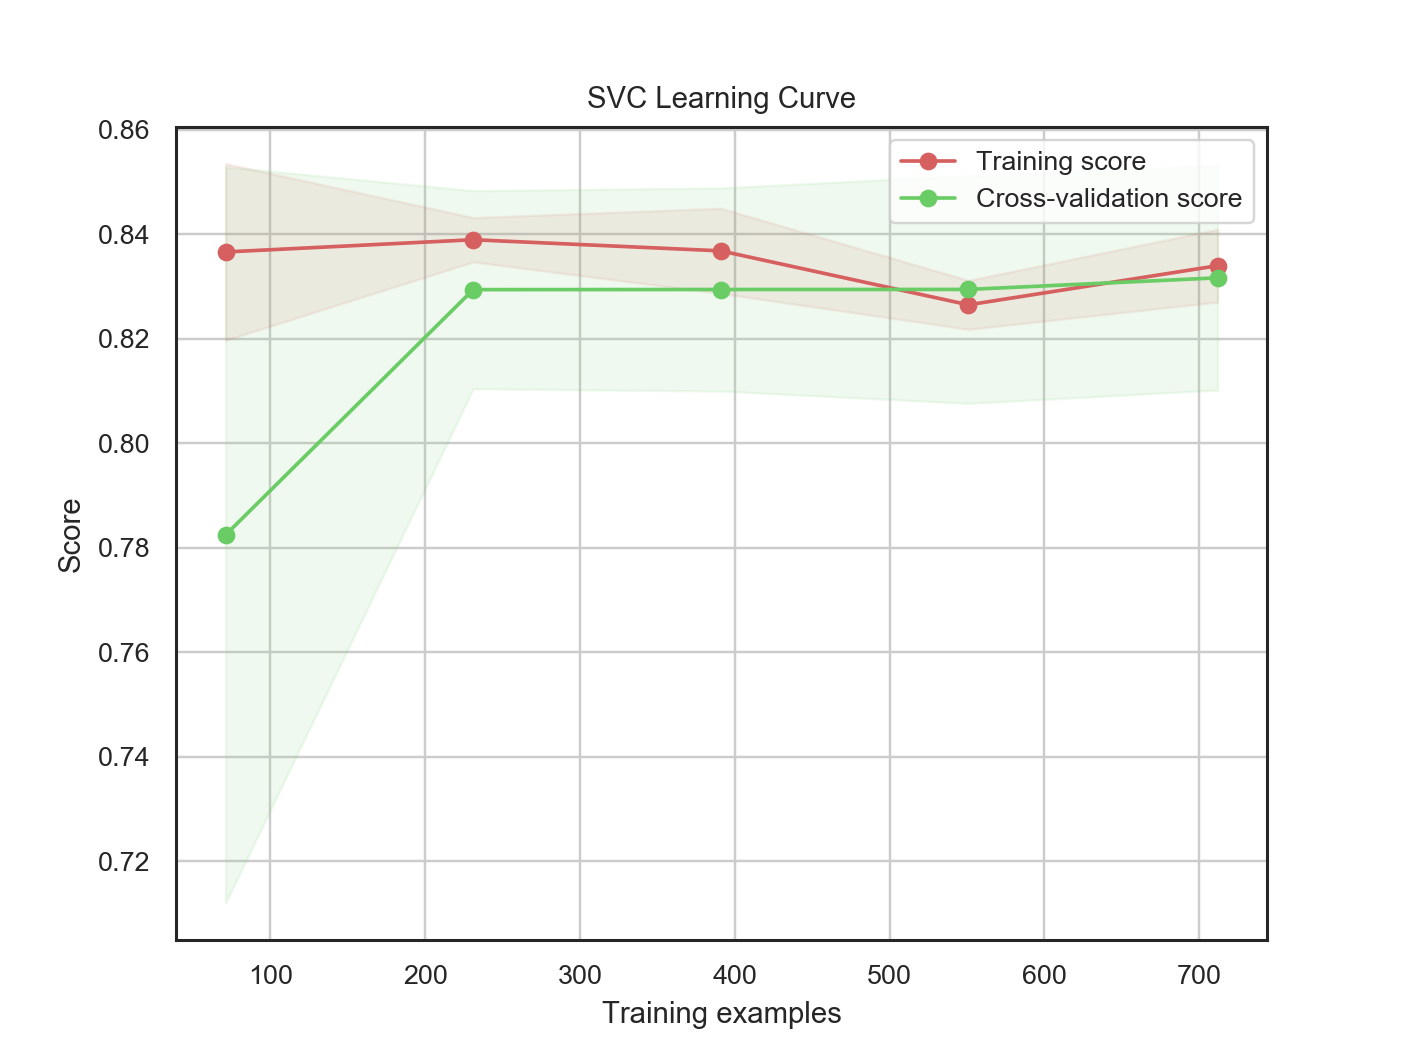

<module 'matplotlib.pyplot' from '/Users/Yunhao/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [766]:
plot_learning_curve(rf,'RF Learning Curve',X_train,y,cv = 5,train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(xgb,'XGB Learning Curve',X_train,y,cv = 5,train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(knn,'KNN Learning Curve',X_train,y,cv = 5,train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(svc,'SVC Learning Curve',X_train,y,cv = 5,train_sizes=np.linspace(.1, 1.0, 5))


### Stacking

In [767]:
from sklearn.model_selection import KFold

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(NFOLDS, random_state=SEED)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [768]:
rf_oof_train,rf_oof_test = get_oof(rf, X_train.values, y, X_test.values)
xgb_oof_train,xgb_oof_test = get_oof(xgb, X_train.values, y, X_test.values)
knn_oof_train,knn_oof_test = get_oof(knn, X_train.values, y, X_test.values)
svc_oof_train,svc_oof_test = get_oof(svc, X_train.values, y, X_test.values)


In [769]:
x_train_stack = np.concatenate((rf_oof_train,xgb_oof_train,knn_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate((rf_oof_test,xgb_oof_test,knn_oof_test,svc_oof_test), axis=1)


In [777]:
LR_grid_values = {'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

run_gs = False
if run_gs:
    LR = LogisticRegression()
    best_param = Grid_auc(LR,LR_grid_values,'LR')
    
else: 
    LR = LogisticRegression(**best_param)
    print_cv_score(LR,'LR',5)

Model LR CV score: 0.82047


# Generate File

In [778]:
y_pred = LR.fit(x_train_stack,y).predict(x_test_stack)
# y_pred = rf.fit(X_train,y).predict(X_test)
temp = pd.DataFrame(pd.read_csv('test.csv')['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv('submission.csv', index = False)